# K-Means Clustering Analysis for Wildfire Data
This notebook implements K-Means clustering for a large wildfire dataset using:
1. Mini-batch K-means for memory efficiency
2. Feature scaling and encoding
3. Dimensionality reduction
4. Cluster validation techniques

In [9]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# For memory management
import gc
import psutil

def print_memory_usage():
    """Print current memory usage"""
    process = psutil.Process()
    print(f"Memory usage: {process.memory_info().rss / 1024 / 1024:.2f} MB")

## Data Loading and Preprocessing


In [10]:
# Load and prepare data efficiently
def load_data(filepath, chunk_size=None):
    """
    Load data with optional chunking
    Returns: DataFrame or DataFrameIterator
    """
    if chunk_size:
        return pd.read_csv(filepath, chunksize=chunk_size)
    return pd.read_csv(filepath)

# Load initial sample to analyze structure
df_sample = pd.read_csv(r'C:\Users\Favour Sukat\OneDrive - Heriot-Watt University\SEMESTER 1(Septermber)\Data Mining and Machine Learning\group-coursework-bots-ahead\data\wildifire2.csv', nrows=1000)
print("Sample data structure:")
print(df_sample.info())

Sample data structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Unnamed: 0                 1000 non-null   int64  
 1   FIRE_DAY                   1000 non-null   object 
 2   FIRE_MONTH                 1000 non-null   object 
 3   Fire_Duration              1000 non-null   int64  
 4   FIRE_SIZE                  1000 non-null   float64
 5   STATE                      1000 non-null   object 
 6   LATITUDE                   1000 non-null   float64
 7   LONGITUDE                  1000 non-null   float64
 8   NWCG_GENERAL_CAUSE         1000 non-null   object 
 9   NWCG_CAUSE_CLASSIFICATION  1000 non-null   object 
dtypes: float64(3), int64(2), object(5)
memory usage: 78.3+ KB
None


We will encode the categorical features for clustering analysis and scale the numeric features


In [11]:
def prepare_features(df):
    """
    Prepare features for clustering:
    1. Encode categorical variables
    2. Scale numerical features
    3. Exclude cause classification
    """
    # Create copy to avoid modifying original
    df_prep = df.copy()
    
    # Select features for clustering (excluding cause classification)
    categorical_cols = ['FIRE_DAY', 'FIRE_MONTH', 'STATE']
    numerical_cols = ['Fire_Duration', 'FIRE_SIZE', 'LATITUDE', 'LONGITUDE']
    
    # Encode categorical variables
    le = LabelEncoder()
    for col in categorical_cols:
        df_prep[col] = le.fit_transform(df_prep[col])
    
    # Scale numerical features
    scaler = StandardScaler()
    df_prep[numerical_cols] = scaler.fit_transform(df_prep[numerical_cols])
    
    # Select only the features we want to use for clustering
    features_for_clustering = categorical_cols + numerical_cols
    df_cluster = df_prep[features_for_clustering]
    
    return df_cluster, scaler, le


Implement Mini-Batch K-Means clustering to handle the large dataset.

In [12]:
# Implement Mini-batch K-means
def minibatch_kmeans_analysis(data, k_range=range(2, 11), batch_size=1000):
    """
    Perform Mini-batch K-means clustering
    Returns: Dictionary of results
    """
    results = {}
    
    for k in k_range:
        kmeans = MiniBatchKMeans(
            n_clusters=k,
            batch_size=batch_size,
            random_state=42
        )
        
        # Fit and predict
        labels = kmeans.fit_predict(data)
        
        # Calculate metrics
        results[k] = {
            'inertia': kmeans.inertia_,
            'silhouette': silhouette_score(data, labels, sample_size=10000)
        }
        
        # Clear memory
        gc.collect()
        
    return results

## Run Clustering Analysis
This is the pipeline for the clustering analysis


In [13]:
def plot_clustering_results(results):
    """
    Visualize clustering results:
    1. Elbow curve for inertia
    2. Silhouette scores
    """
    # Extract values from results
    k_values = list(results.keys())
    inertias = [results[k]['inertia'] for k in k_values]
    silhouette_scores = [results[k]['silhouette'] for k in k_values]
    
    # Print values for verification
    print("\nClustering Results:")
    for k in k_values:
        print(f"k={k}:")
        print(f"  Inertia: {results[k]['inertia']:.2f}")
        print(f"  Silhouette Score: {results[k]['silhouette']:.3f}")
    
    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot elbow curve
    ax1.plot(k_values, inertias, 'bo-')
    ax1.set_xlabel('Number of Clusters (k)')
    ax1.set_ylabel('Inertia')
    ax1.set_title('Elbow Method')
    
    # Plot silhouette scores
    ax2.plot(k_values, silhouette_scores, 'ro-')
    ax2.set_xlabel('Number of Clusters (k)')
    ax2.set_ylabel('Silhouette Score')
    ax2.set_title('Silhouette Analysis')
    
    plt.tight_layout()
    plt.show()

Loading data...
Memory usage: 546.65 MB

Preparing features...
Memory usage: 590.67 MB

Performing clustering...

Clustering Results:
k=2:
  Inertia: 63980269.15
  Silhouette Score: 0.609
k=3:
  Inertia: 39250683.64
  Silhouette Score: 0.494
k=4:
  Inertia: 35628081.05
  Silhouette Score: 0.327
k=5:
  Inertia: 25054354.01
  Silhouette Score: 0.339
k=6:
  Inertia: 23560504.06
  Silhouette Score: 0.311
k=7:
  Inertia: 21932427.92
  Silhouette Score: 0.277
k=8:
  Inertia: 19229395.39
  Silhouette Score: 0.313
k=9:
  Inertia: 18367792.86
  Silhouette Score: 0.315
k=10:
  Inertia: 16762847.22
  Silhouette Score: 0.303


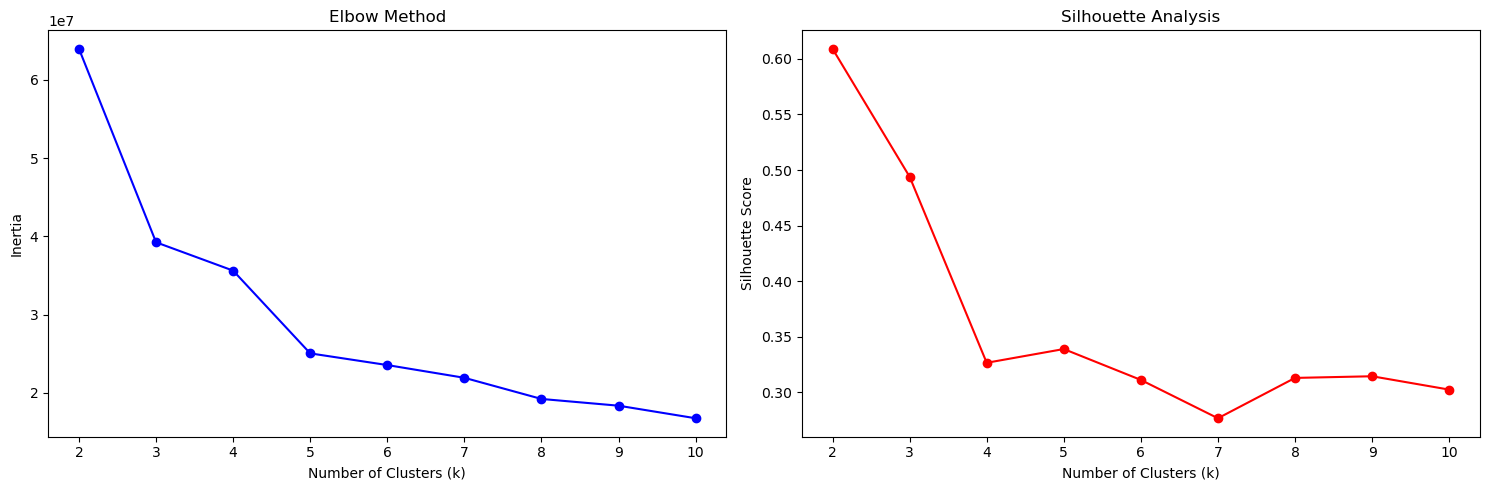

In [14]:
# Main analysis pipeline
def main():
    # 1. Load data in chunks 
    print("Loading data...")
    df = load_data(r'C:\Users\Favour Sukat\Downloads\group-coursework-bots-ahead\data\wildifireStage1.csv')
    print_memory_usage()
    
    # 2. Prepare features
    print("\nPreparing features...")
    df_prepared, scaler, le = prepare_features(df)
    print_memory_usage()
    
    # 3. Run clustering
    print("\nPerforming clustering...")
    results = minibatch_kmeans_analysis(df_prepared)
    
    # 4. Visualize results
    plot_clustering_results(results)
    
    return results, df_prepared

results, df_prepared = main()

## Initial Clustering Analysis

Our results show conflicting information:
1. The elbow plot suggests k=3 or k=5 might be optimal:
   - Large inertia drop from k=2 to k=3
   - Another significant drop from k=4 to k=5
2. Silhouette scores suggest k=2 is optimal:
   - Highest score at k=2 (0.611)
   - Consistent decrease as k increases

This conflict suggests we should:
1. Investigate why our metrics disagree
2. Consider if our feature selection is appropriate
3. Visualize the clusters to understand the patterns

# Cluster Analysis for k=2, k=3 and k=5

## Define Analysis Function
Create a function to analyze cluster characteristics

In [15]:
def analyze_clusters(df_cluster, n_clusters):
    """
    Analyze cluster characteristics without using labels
    Focus on the features we used for clustering:
    - FIRE_DAY
    - FIRE_MONTH
    - STATE
    - Fire_Duration
    - FIRE_SIZE
    - LATITUDE
    - LONGITUDE
    """
    # Fit MiniBatchKMeans
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(df_cluster)
    
    # Add cluster labels to our feature dataframe
    df_analysis = df_cluster.copy()
    df_analysis['Cluster'] = cluster_labels
    
    print(f"\nAnalysis for k={n_clusters} clusters:")
    
    # Overall cluster distribution
    print("\nCluster Distribution:")
    print(df_analysis['Cluster'].value_counts(normalize=True))
    
    # Analyze each cluster
    for i in range(n_clusters):
        cluster_data = df_analysis[df_analysis['Cluster'] == i]
        print(f"\nCluster {i} Characteristics:")
        
        # Numerical features statistics
        print("\nNumerical Features:")
        print(cluster_data[['FIRE_SIZE', 'Fire_Duration', 'LATITUDE', 'LONGITUDE']].describe())
        
        # Month distribution
        print("\nMonth Distribution:")
        print(cluster_data['FIRE_MONTH'].value_counts().sort_index())
    
    return df_analysis, kmeans

## Analyze k=2 Clusters
First, let's analyze the characteristics of two clusters


Analysis for k=2 clusters:

Cluster Distribution:
Cluster
1    0.519647
0    0.480353
Name: proportion, dtype: float64

Cluster 0 Characteristics:

Numerical Features:
           FIRE_SIZE  Fire_Duration       LATITUDE      LONGITUDE
count  467323.000000  467323.000000  467323.000000  467323.000000
mean       -0.003026      -0.025215      -0.391118      -0.164006
std         0.959761       0.970536       0.902296       1.017530
min        -0.032907      -0.139117      -3.603878      -4.826188
25%        -0.032868      -0.139117      -1.021270      -1.121161
50%        -0.032712      -0.139117      -0.605637       0.396696
75%        -0.031732      -0.139117       0.253309       0.691688
max       160.743814      61.170099       6.392891       1.703373

Month Distribution:
FIRE_MONTH
0     46780
1     46683
2     14173
3     37723
4     25514
5     60099
6     48076
7     58140
8     44067
9     24820
10    28981
11    32267
Name: count, dtype: int64

Cluster 1 Characteristics:

Numeri

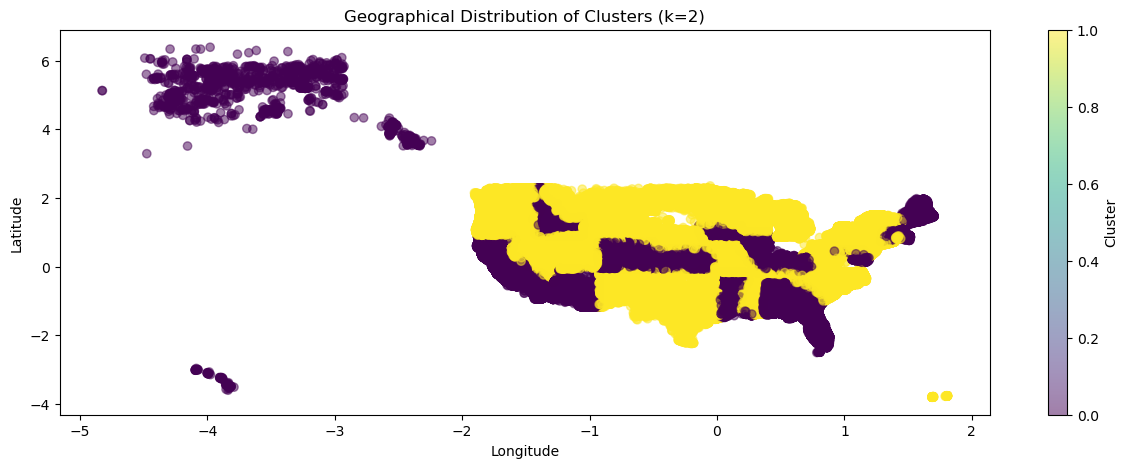

In [16]:
df_with_clusters_2, kmeans_2 = analyze_clusters(df_prepared, 2)

# Visualize geographical distribution
plt.figure(figsize=(15, 5))
plt.scatter(df_with_clusters_2['LONGITUDE'], 
           df_with_clusters_2['LATITUDE'], 
           c=df_with_clusters_2['Cluster'],
           alpha=0.5)
plt.title('Geographical Distribution of Clusters (k=2)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Cluster')
plt.show()

## Analyze k=3 Clusters
Now, let's analyze the characteristics of three clusters to see if we get more distinct patterns


Analysis for k=3 clusters:

Cluster Distribution:
Cluster
0    0.467993
1    0.373070
2    0.158937
Name: proportion, dtype: float64

Cluster 0 Characteristics:

Numerical Features:
           FIRE_SIZE  Fire_Duration       LATITUDE      LONGITUDE
count  455299.000000  455299.000000  455299.000000  455299.000000
mean       -0.002270      -0.023214      -0.431192      -0.206023
std         0.972338       0.975491       0.874732       0.996401
min        -0.032907      -0.139117      -3.603878      -4.826188
25%        -0.032868      -0.139117      -1.032176      -1.128230
50%        -0.032712      -0.139117      -0.628753       0.332801
75%        -0.031732      -0.139117       0.198584       0.681426
max       160.743814      61.170099       6.392891       1.517169

Month Distribution:
FIRE_MONTH
0     43181
1     45672
2     14040
3     37365
4     25365
5     59202
6     47404
7     56942
8     41529
9     24377
10    28636
11    31586
Name: count, dtype: int64

Cluster 1 Characteri

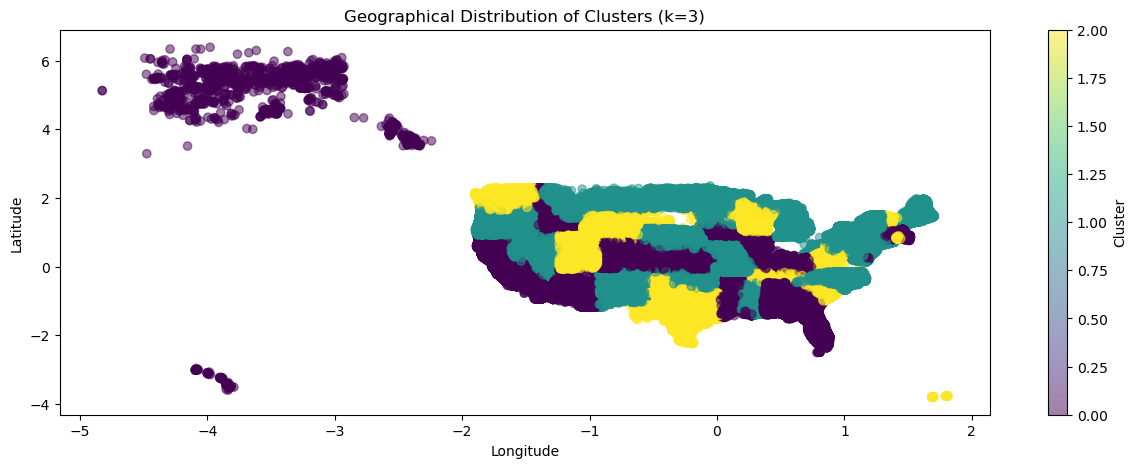

In [17]:
df_with_clusters_3, kmeans_3 = analyze_clusters(df_prepared, 3)

# Visualize geographical distribution
plt.figure(figsize=(15, 5))
plt.scatter(df_with_clusters_3['LONGITUDE'], 
           df_with_clusters_3['LATITUDE'], 
           c=df_with_clusters_3['Cluster'],
           alpha=0.5)
plt.title('Geographical Distribution of Clusters (k=3)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Cluster')
plt.show()

## Analyze k=5 Clusters
Now, let's analyze the characteristics of five clusters to see if we get more distinct patterns


Analysis for k=5 clusters:

Cluster Distribution:
Cluster
0    0.264933
1    0.206421
3    0.200722
4    0.169738
2    0.158186
Name: proportion, dtype: float64

Cluster 0 Characteristics:

Numerical Features:
           FIRE_SIZE  Fire_Duration       LATITUDE      LONGITUDE
count  257747.000000  257747.000000  257747.000000  257747.000000
mean       -0.003410      -0.031715      -0.488659      -0.385284
std         0.903762       0.898635       0.820294       1.008073
min        -0.032907      -0.139117      -3.603878      -4.826188
25%        -0.032868      -0.139117      -1.013544      -1.370605
50%        -0.032751      -0.139117      -0.665768      -0.662136
75%        -0.032006      -0.139117       0.133860       0.635172
max       122.613632      61.170099       6.392891       1.401134

Month Distribution:
FIRE_MONTH
1         7
2      1080
3      5787
4      8122
5     40174
6     43338
7     45658
8     38886
9     20131
10    25222
11    29342
Name: count, dtype: int64

Clus

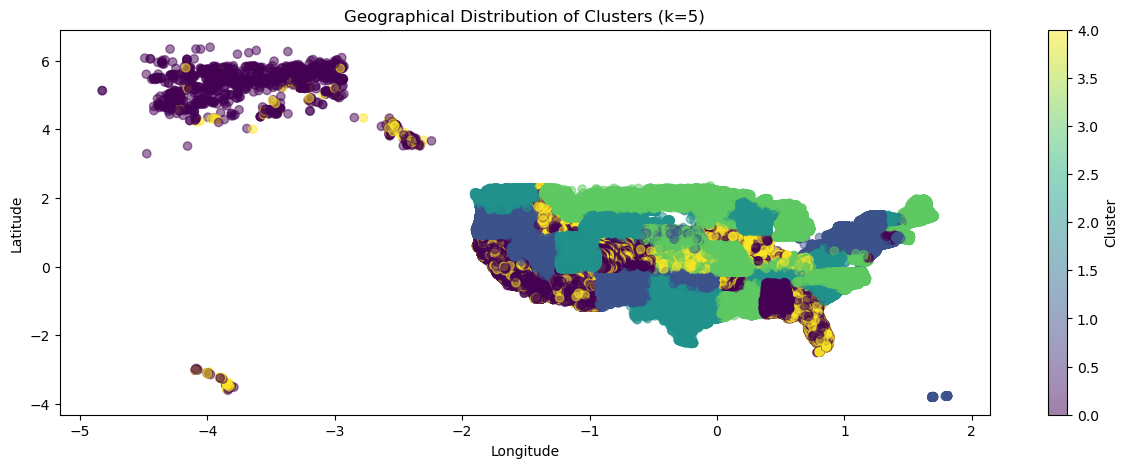

In [18]:
df_with_clusters_5, kmeans_5 = analyze_clusters(df_prepared, 5)

# Visualize geographical distribution
plt.figure(figsize=(15, 5))
plt.scatter(df_with_clusters_5['LONGITUDE'], 
           df_with_clusters_5['LATITUDE'], 
           c=df_with_clusters_5['Cluster'],
           alpha=0.5)
plt.title('Geographical Distribution of Clusters (k=5)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Cluster')
plt.show()

Mixed feature types may be affecting our cluster quality
High dimensionality (7 features) could mask important patterns in our clusters
Thus we should perform dimensionality reduction using PCA

# Dimensionality Reduction 
After observing overlapping geographical clusters, let's try PCA to find more distinct patterns.

In [19]:
# Import additional libraries
from sklearn.decomposition import PCA


Feature importance in principal components:

PC1 contributions:
FIRE_DAY: 0.000
FIRE_MONTH: 0.012
STATE: 0.999
Fire_Duration: 0.003
FIRE_SIZE: 0.000
LATITUDE: 0.027
LONGITUDE: 0.011

PC2 contributions:
FIRE_DAY: 0.001
FIRE_MONTH: 1.000
STATE: 0.013
Fire_Duration: 0.005
FIRE_SIZE: 0.002
LATITUDE: 0.013
LONGITUDE: 0.001

PC3 contributions:
FIRE_DAY: 1.000
FIRE_MONTH: 0.001
STATE: 0.000
Fire_Duration: 0.001
FIRE_SIZE: 0.001
LATITUDE: 0.000
LONGITUDE: 0.005

PC4 contributions:
FIRE_DAY: 0.003
FIRE_MONTH: 0.010
STATE: 0.008
Fire_Duration: 0.522
FIRE_SIZE: 0.318
LATITUDE: 0.500
LONGITUDE: 0.614

PC5 contributions:
FIRE_DAY: 0.002
FIRE_MONTH: 0.001
STATE: 0.004
Fire_Duration: 0.379
FIRE_SIZE: 0.745
LATITUDE: 0.350
LONGITUDE: 0.423

PC6 contributions:
FIRE_DAY: 0.000
FIRE_MONTH: 0.001
STATE: 0.001
Fire_Duration: 0.764
FIRE_SIZE: 0.586
LATITUDE: 0.139
LONGITUDE: 0.233

PC7 contributions:
FIRE_DAY: 0.003
FIRE_MONTH: 0.011
STATE: 0.028
Fire_Duration: 0.028
FIRE_SIZE: 0.026
LATITUDE: 0.780
LONGIT

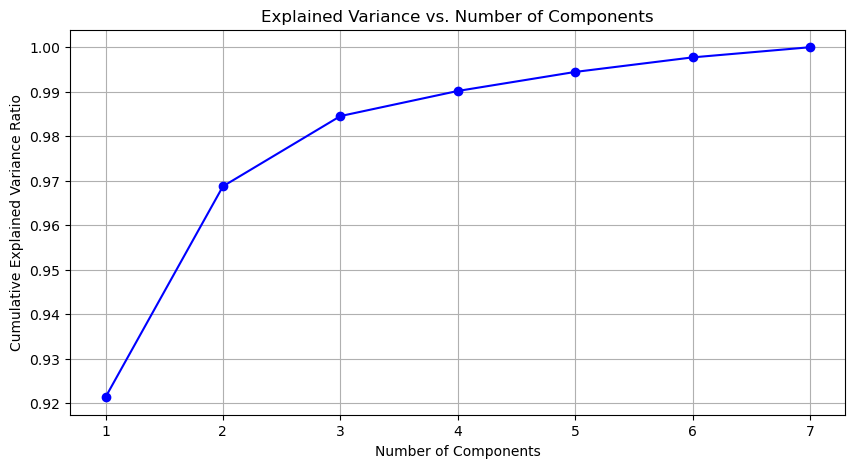

In [20]:
# Define PCA analysis function
def analyze_with_pca(df_prepared):
    # Apply PCA to understand feature importance
    pca = PCA()
    pca.fit(df_prepared)
    
    # Print feature importance
    feature_names = ['FIRE_DAY', 'FIRE_MONTH', 'STATE', 'Fire_Duration', 
                    'FIRE_SIZE', 'LATITUDE', 'LONGITUDE']
    
    print("\nFeature importance in principal components:")
    for i, pc in enumerate(pca.components_):
        print(f"\nPC{i+1} contributions:")
        for name, value in zip(feature_names, abs(pc)):
            print(f"{name}: {value:.3f}")
            
    # Print explained variance
    print("\nExplained variance ratios:")
    for i, ratio in enumerate(pca.explained_variance_ratio_):
        print(f"PC{i+1}: {ratio:.4f}")
        
    # Visualize explained variance
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
            np.cumsum(pca.explained_variance_ratio_), 'bo-')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.title('Explained Variance vs. Number of Components')
    plt.grid(True)
    plt.show()
    
    return pca

# Run PCA analysis
pca_results = analyze_with_pca(df_prepared)

The clustering is primarily driven by just two factors:
Geographic location (through STATE) and Seasonality (through FIRE_MONTH).
These are overwhelming the actual fire characteristics in our clustering

# Revised Clustering Approach
Let's focus on clustering using only fire-specific characteristics (size and duration) first, then analyze geographical and temporal patterns within these clusters.

Clustering with fire-specific features:

Clustering Results:
k=2:
  Inertia: 1790191.65
  Silhouette Score: 0.919
k=3:
  Inertia: 1786667.32
  Silhouette Score: 0.873
k=4:
  Inertia: 1806833.17
  Silhouette Score: 0.790
k=5:
  Inertia: 1375001.85
  Silhouette Score: 0.546
k=6:
  Inertia: 1344934.70
  Silhouette Score: 0.821
k=7:
  Inertia: 1367801.56
  Silhouette Score: 0.498
k=8:
  Inertia: 1400379.23
  Silhouette Score: 0.176
k=9:
  Inertia: 1346266.22
  Silhouette Score: 0.306
k=10:
  Inertia: 1320799.79
  Silhouette Score: 0.461


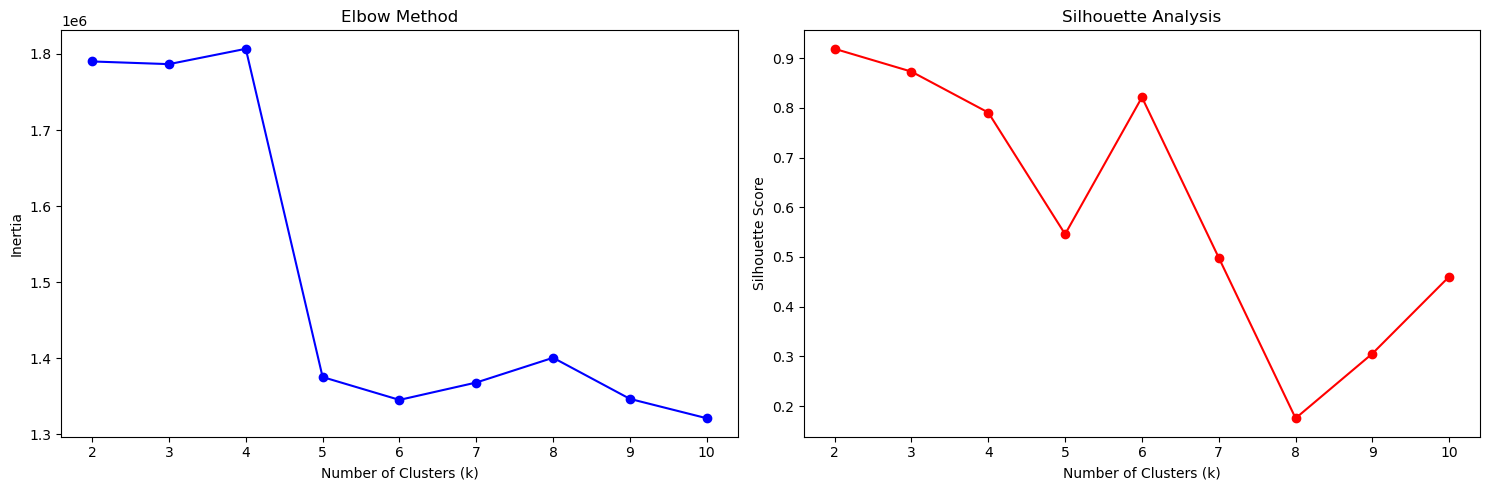

In [21]:
# Modify feature preparation to use only fire characteristics
def prepare_fire_features(df):
    """
    Prepare only fire-specific features for clustering:
    - FIRE_SIZE
    - Fire_Duration
    """
    # Create copy and select features
    df_prep = df.copy()
    fire_features = ['FIRE_SIZE', 'Fire_Duration']
    
    # Scale features
    scaler = StandardScaler()
    df_cluster = pd.DataFrame(
        scaler.fit_transform(df_prep[fire_features]),
        columns=fire_features
    )
    
    return df_cluster, scaler

# Prepare the data
df_fire_features, scaler = prepare_fire_features(df_prepared)

print("Clustering with fire-specific features:")
results_fire = minibatch_kmeans_analysis(df_fire_features)
plot_clustering_results(results_fire)

While the elbow plot doesn't show a clear elbow at k=2
We select k=2 because:
- It has an excellent silhouette score (0.92)
- k=5 has a much lower silhouette score (0.546)
- Higher k values show inconsistent cluster quality


Let's analyze these two clusters in detail to understand their characteristics.


Cluster Distribution:
Cluster
1    0.928382
0    0.071618
Name: proportion, dtype: float64

Cluster 0 Characteristics:

Fire Characteristics:
          FIRE_SIZE  Fire_Duration
count  69675.000000   69675.000000
mean       0.384420       1.624701
std        3.714815       3.330509
min       -0.032908      -0.139117
25%       -0.032868       0.197747
50%       -0.032516       0.534611
75%       -0.021149       1.376770
max      218.749726      61.170099

Month Distribution:
FIRE_MONTH
0      5025
1     16712
2       575
3      1372
4       759
5     17578
6      8224
7      3246
8      4760
9      2214
10     2756
11     6454
Name: count, dtype: int64

Top 5 States:
STATE
47    9942
36    6408
30    6334
44    5242
12    5196
Name: count, dtype: int64

Cluster 1 Characteristics:

Fire Characteristics:
           FIRE_SIZE  Fire_Duration
count  903200.000000  903200.000000
mean       -0.029655      -0.125333
std         0.018032       0.046169
min        -0.032908      -0.139117
25%    

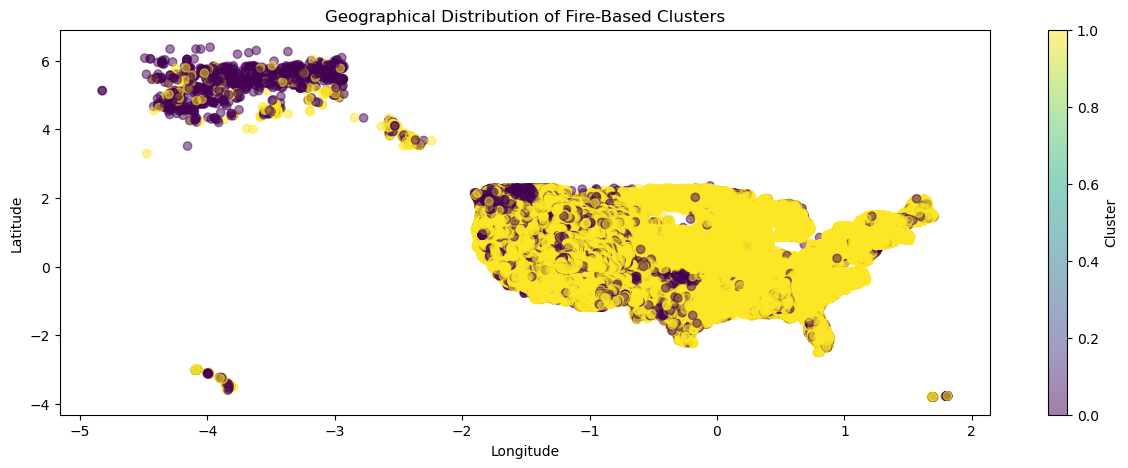

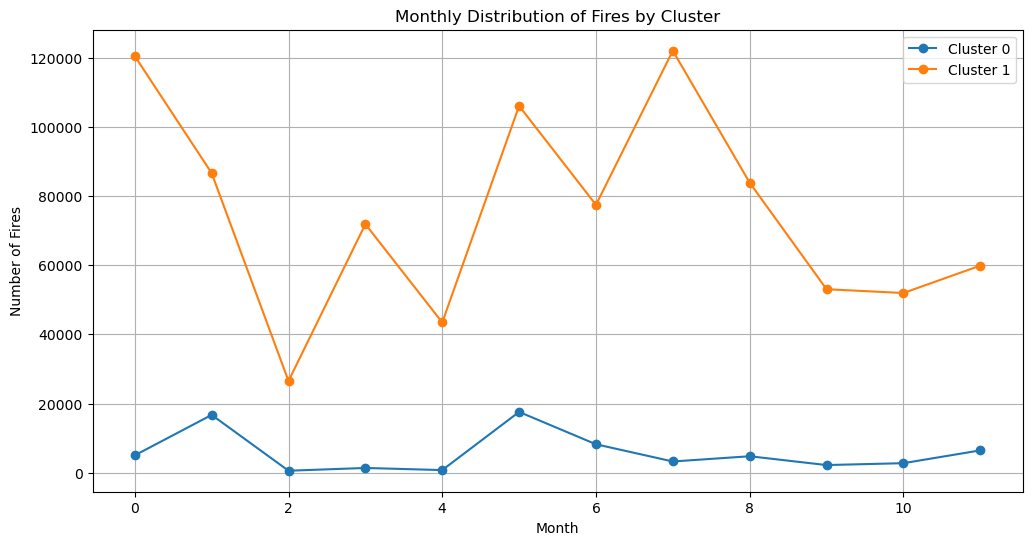

In [22]:
def analyze_fire_clusters(df_original, df_fire_features, n_clusters=2):
    """
    Analyze fire clusters and their relationship to other features
    """
    # Cluster the fire features
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(df_fire_features)
    
    # Add cluster labels to original data
    df_analysis = df_original.copy()
    df_analysis['Cluster'] = cluster_labels
    
    # Basic cluster distribution
    print("\nCluster Distribution:")
    print(df_analysis['Cluster'].value_counts(normalize=True))
    
    # Analyze each cluster
    for i in range(n_clusters):
        cluster_data = df_analysis[df_analysis['Cluster'] == i]
        print(f"\nCluster {i} Characteristics:")
        
        # Fire characteristics
        print("\nFire Characteristics:")
        print(cluster_data[['FIRE_SIZE', 'Fire_Duration']].describe())
        
        # Temporal patterns
        print("\nMonth Distribution:")
        print(cluster_data['FIRE_MONTH'].value_counts().sort_index())
        
        # Geographical patterns
        print("\nTop 5 States:")
        print(cluster_data['STATE'].value_counts().head())
    
    # Visualize geographical distribution
    plt.figure(figsize=(15, 5))
    plt.scatter(df_analysis['LONGITUDE'], 
               df_analysis['LATITUDE'], 
               c=df_analysis['Cluster'],
               alpha=0.5)
    plt.title('Geographical Distribution of Fire-Based Clusters')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.colorbar(label='Cluster')
    plt.show()
    
    # Visualize seasonal patterns
    plt.figure(figsize=(12, 6))
    for i in range(n_clusters):
        cluster_data = df_analysis[df_analysis['Cluster'] == i]
        monthly_counts = cluster_data['FIRE_MONTH'].value_counts().sort_index()
        plt.plot(monthly_counts.index, monthly_counts.values, 
                label=f'Cluster {i}', marker='o')
    plt.title('Monthly Distribution of Fires by Cluster')
    plt.xlabel('Month')
    plt.ylabel('Number of Fires')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return df_analysis, kmeans

# Run the analysis
df_clustered, kmeans_final = analyze_fire_clusters(df_prepared, df_fire_features)

## The clustering has identified a small but distinct group of severe fires (7.2%)

## These severe fires are:
- Much larger and longer-lasting
- More variable in characteristics
- Have different seasonal patterns

## The majority of fires (92.8%) are very consistent in size and duration

# Lets get state mapping from the original data


In [23]:
# Get state mapping from the original data
def get_state_mapping(df_original):
    """
    Create a mapping between encoded state values and original state names
    """
    le = LabelEncoder()
    original_states = df_original['STATE'].unique()
    encoded_states = le.fit_transform(original_states)
    
    # Create mapping dictionary
    state_mapping = dict(zip(encoded_states, original_states))
    
    print("\nState Code Mapping:")
    for code, state in sorted(state_mapping.items()):
        print(f"Code {code}: {state}")
    
    return state_mapping

# Load original data to get state names
df_full = pd.read_csv(r'C:\Users\Favour Sukat\OneDrive - Heriot-Watt University\SEMESTER 1(Septermber)\Data Mining and Machine Learning\group-coursework-bots-ahead\data\wildifire2.csv')

# Create the mapping
state_mapping = get_state_mapping(df_full)




State Code Mapping:
Code 0: AK
Code 1: AL
Code 2: AR
Code 3: AZ
Code 4: CA
Code 5: CO
Code 6: CT
Code 7: DE
Code 8: FL
Code 9: GA
Code 10: HI
Code 11: IA
Code 12: ID
Code 13: IL
Code 14: IN
Code 15: KS
Code 16: KY
Code 17: LA
Code 18: MA
Code 19: MD
Code 20: ME
Code 21: MI
Code 22: MN
Code 23: MO
Code 24: MS
Code 25: MT
Code 26: NC
Code 27: ND
Code 28: NE
Code 29: NH
Code 30: NJ
Code 31: NM
Code 32: NV
Code 33: NY
Code 34: OH
Code 35: OK
Code 36: OR
Code 37: PA
Code 38: PR
Code 39: RI
Code 40: SC
Code 41: SD
Code 42: TN
Code 43: TX
Code 44: UT
Code 45: VA
Code 46: VT
Code 47: WA
Code 48: WI
Code 49: WV
Code 50: WY


In [27]:
# Get state mapping from the original data
def get_month_mapping(df_original):
    """
    Create a mapping between encoded state values and original state names
    """
    le = LabelEncoder()
    original_months = df_original['FIRE_MONTH'].unique()
    encoded_months = le.fit_transform(original_months)
    
    # Create mapping dictionary
    month_mapping = dict(zip(encoded_months, original_months))
    
    print("\nMonth Mapping:")
    for code, month in sorted(month_mapping.items()):
        print(f"Month {code}: {month}")
    
    return month_mapping

# Load original data to get state names
df_full = pd.read_csv(r'C:\Users\Favour Sukat\OneDrive - Heriot-Watt University\SEMESTER 1(Septermber)\Data Mining and Machine Learning\group-coursework-bots-ahead\data\wildifire2.csv')

# Create the mapping
month_mapping = get_month_mapping(df_full)




Month Mapping:
Month 0: April
Month 1: August
Month 2: December
Month 3: February
Month 4: January
Month 5: July
Month 6: June
Month 7: March
Month 8: May
Month 9: November
Month 10: October
Month 11: September


Lets see what this mapping tells us about the top fires for each cluster.


In [24]:
print("\nCluster 0 (Severe Fires) Top States:")
for code in [47, 36, 30, 44, 12]:  # From our previous results
    print(f"Code {code}: {state_mapping[code]}")

print("\nCluster 1 (Regular Fires) Top States:")
for code in [9, 33, 4, 26, 8]:  # From our previous results
    print(f"Code {code}: {state_mapping[code]}")


Cluster 0 (Severe Fires) Top States:
Code 47: WA
Code 36: OR
Code 30: NJ
Code 44: UT
Code 12: ID

Cluster 1 (Regular Fires) Top States:
Code 9: GA
Code 33: NY
Code 4: CA
Code 26: NC
Code 8: FL


## Cluster Characteristics Analysis

The two-cluster solution reveals a clear distinction in fire patterns:

### Cluster 0: "Severe Fires" (7.2% of total)
- **Characteristics:**
  - Larger size (mean: 0.384, std: 3.715)
  - Longer duration (mean: 1.625, std: 3.331)
  - High variability in both size and duration
  - Contains extreme cases (max size: 218.75, max duration: 61.17)
- **Top States:** Washington, Oregon, New Jersey, Utah, Idaho
- **Peak Months:** June, July, August

### Cluster 1: "Regular Fires" (92.8% of total)
- **Characteristics:**
  - Consistently smaller size (mean: -0.030, std: 0.018)
  - Shorter duration (mean: -0.125, std: 0.046)
  - Very consistent characteristics (low std dev)
- **Top States:** Georgia, New York, California, North Carolina, Florida
- **Peak Months:** March, April, July

### Key Insights
1. Fire behavior naturally clusters into two distinct groups based on size and duration
2. The Pacific Northwest experiences more severe fires than other regions
3. East Coast states predominantly experience regular fires
4. California, despite its reputation, falls into the regular fire cluster

### Implications for Modeling
1. The two-cluster structure suggests different fire behavior patterns that might require separate modeling approaches
2. Geographic location might be less important than fire characteristics for prediction